In [1]:
import numpy as np
from Bio import Entrez

In [2]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams["legend.frameon"] = False
%matplotlib inline

Let's let the nice folks at NCBI know who we are.

In [3]:
Entrez.email = "sarabizjak97@gmail.com"
# "sara.bizjak@student.fmf.uni-lj.si"

In [4]:
# In order to import from the python file without hassle, we add the current
# directory to the python path
import sys
sys.path.append(".")
from helper_functions import load, extract_gt_orfs, find_all_orfs, translate_to_protein

# Paramecium tetraurelia

Paramecia are unicellular organisms, which move around using cilia. Cilia are like little hairs attached to the cell membrane, which the animal can vibrate to move around.

![](https://upload.wikimedia.org/wikipedia/commons/b/bd/Инфузория_туфелька_поедает_бактерии%21.gif)

Paramecia are widespread in freshwater, brackish, and marine environments and are often very abundant in stagnant basins and ponds. If you want, you can read more about them on [Wikipedia](https://en.wikipedia.org/wiki/Paramecium).

This is a model organism, meaning it has been very throughoutly studied. We're going to see how many genes we can identify ourselves and compare that to the true gene annotations.

In [5]:
organism_id = "NC_006058"  # Paramecium tetraurelia

In [6]:
start_codons = ["ATG"]
stop_codons = ["TGA"]

Fetch the Paramecium genome from NCBI.

In [7]:
record = load(organism_id)
record

SeqRecord(seq=Seq('GTTTATATTTTTACACTGTTTCCATCCTTATTTTCAAAAAAAAATTTACAATTT...CTT'), id='NC_006058.1', name='NC_006058', description='Paramecium tetraurelia macronuclear, complete genome', dbxrefs=['Project:12726', 'BioProject:PRJNA12726'])

How long is the genome?

In [8]:
print("{:,} bases".format(len(record.seq)))

984,602 bases


## Problem 1

Find all the open reading frames (ORFs) in the genome. We define an ORF to be the longest contiguous sequence of triplets (codons) between a start and a stop codon. 

**TASK:**
Implement the `find_orfs` and `find_all_orfs` functions in `helper_functions.py`. You can verify your implementation against the provided unit tests (your code will be run against different examples for grading). `find_orfs` should find ORFs for a single offset e.g. [ATGTAATGTTGATTA]TG, ignoring the final TG. `find_all_orfs` should use `find_orfs` to find _all_ the ORFs in a sequence, i.e. [ATGTAATGTTGATTA]TG, A[TGTAATGTTGATTAT]G, AT[GTAATGTTGATTATG], as well as the ORFs on the reverse complements. See the docstrings and unit tests in `test_helper_functions.py` for expected return types.

Once you have implemented your ORF finder, return to this notebook. In the following cells, you will find the ORFs for the Paramecium tetraurelia genome.

In [9]:
print("Finding ORFs using start/stop codons...")
orf_candidates = find_all_orfs(record.seq, start_codons, stop_codons)
print(f"{len(orf_candidates)} ORF candidates found")

Finding ORFs using start/stop codons...
16646 ORF candidates found


In [10]:
orf_length = np.array([c[2] - c[1] for c in orf_candidates]) / 3  # divide by 3 for codons

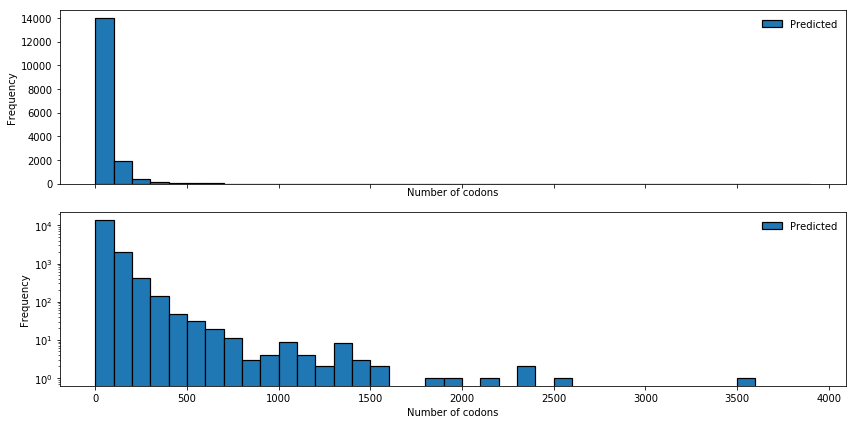

In [11]:
fig, ax = plt.subplots(nrows=2, figsize=(12, 6), sharex=True)
hist_kwargs = dict(bins=list(range(0, 4000, 100)), edgecolor="k", lw=1.2)
for ax_ in ax.ravel():
    ax_.hist(orf_length, color="tab:blue", label="Predicted", **hist_kwargs)
    ax_.set_xlabel("Number of codons"), ax_.set_ylabel("Frequency")
    ax_.legend()
ax[1].set_yscale("log")
plt.tight_layout();

In the top figure, we can immediately notice that almost all of our ORFs are very short. We can plot the same data on a log scale so we can see how long some ORFs really are.

## Problem 2

As we said in the beginning, Paramecium tetraurelia is a well studied organism, so we can check how many of our predicted ORFs are actually real genes.

In [12]:
print("Extracting ORFs from NCBI annotation...")
orfs_gt = extract_gt_orfs(record, start_codons, stop_codons, verbose=False)
print(f"{len(orfs_gt)} ground truth ORFs found")

Extracting ORFs from NCBI annotation...
100 ground truth ORFs found


In [13]:
gt_orf_length = np.array([c[2] - c[1] for c in orfs_gt]) / 3

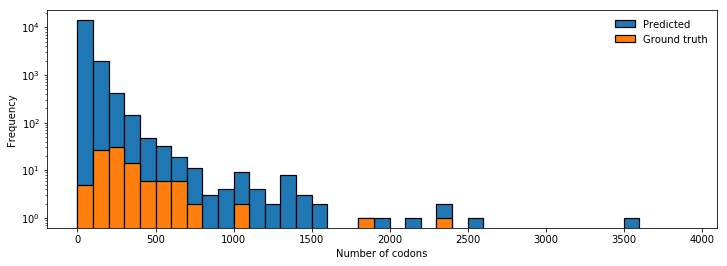

In [14]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.hist(orf_length, color="tab:blue", label="Predicted", **hist_kwargs)
ax.hist(gt_orf_length, color="tab:orange", label="Ground truth", **hist_kwargs)
ax.set_xlabel("Number of codons"), ax.set_ylabel("Frequency")
ax.set_yscale("log")
plt.legend();

**TASK:**
Plot the precision/recall/F1 curves for different thresholds into a single figure and save the result to `problem2.png`. Determine a threshold for the ORF length and save your answers into the `bacteria_threshold` and `bacteria_reason` variables.

In practice, biologists will mostly look through each ORF manually to determine if it is a gene or not. We want to help them by eliminating ORFs that are probably too short to be a gene, but still keep most of the ORFs that actually code for genes. 

In [17]:
# CHECK TP, FP, FN for th = 0

# orf_candidates -> Predicted
# orfs_gt -> Actual

TP = 0
FP = 0
FN = 0

# Counting TP -> Actual YES, Predicted YES
for gt in orfs_gt:
    if gt in orf_candidates:
        TP += 1
        
# Counting FP -> Actual NO, Predicted YES
for candidate in orf_candidates:
    if candidate not in orfs_gt:
        FP += 1

# Counting FN -> Actual YES, Predicted NO
for gt in orfs_gt:
    if gt not in orf_candidates:
        FN += 1
        
print("TP :" + str(TP))
print("FP :" + str(FP))
print("FN :" + str(FN))

precision = TP / (TP + FP)
recall = TP / (TP + FN)
F1 = ( 2 * precision * recall) / (precision + recall)

print("precision: " + str(precision))
print("recall: " + str(recall))
print("F1: " + str(F1))

TP :54
FP :16592
FN :46
precision: 0.0032440225880091315
recall: 0.54
F1: 0.006449301325689717


In [18]:
# FUNCTIONS for lists of candidates and actuals > THRESHOLD

# CANDIDATES: orf_candidates -> orf_length
# ACTUALS: orfs_gt -> gt_orf_length

def make_predicted_list(predicted, th):
    """ Returns a list with ORF candidates with len > threshold. """
    pred_list = []
    for i in range(len(predicted)):
        if orf_length[i] > th:
            pred_list.append(predicted[i])
    return pred_list 
        
### TP ### FP ### FN ###

def counting_TP(predicted, actual, th):
    """ Returns TP value for selected threshold. """
    TP = 0
    # Threshold
    predicted_th = make_predicted_list(predicted, th)  
    # Counting TP -> Actual YES, Predicted YES
    for act in actual:
        if act in predicted_th:
            TP += 1
    return TP
     
def counting_FP(predicted, actual, th):
    """ Returns FP value for selected threshold. """
    FP = 0
    # Threshold
    predicted_th = make_predicted_list(predicted, th) 
    # Counting FP -> Actual NO, Predicted YES
    for pred in predicted_th:
        if pred not in actual:
            FP += 1
    return FP
       
def counting_FN(predicted, actual, th):
    """ Returns FN value for selected threshold. """
    FN = 0
    # Threshold
    predicted_th = make_predicted_list(predicted, th)
    # Counting FN -> Actual YES, Predicted NO
    for act in actual:
        if act not in predicted_th:
            FN += 1
    return FN

### PRECISION ### RECALL ### F1 ###

def calculating_pre_rec_f1(predicted, actual, th):
    """ Returns a list [precision, recall, F1] for selected th. """
    # TP, FP, FN
    TP = counting_TP(predicted, actual, th)
    FP = counting_FP(predicted, actual, th)
    FN = counting_FN(predicted, actual, th)
    # precision, recall, F1
    if TP + FP != 0:
        precision = TP / (TP + FP)
    else:
        precision = 0
    if TP + FN != 0:
        recall = TP / (TP + FN)
    else:
        recall = 0
    if precision + recall != 0:
        F1 = ( 2 * precision * recall) / (precision + recall)
    else:
        F1 = 0
    
    return [precision, recall, F1]


In [19]:
calculating_pre_rec_f1(orf_candidates, orfs_gt, 0)

[0.0032440225880091315, 0.54, 0.006449301325689717]

In [20]:
### PREPARING DATA FOR PLOTTING

# X : th
# Y : pre, rec, f1

x_th = []
y_pre = []
y_rec = []
y_f1 = []

for i in range(0, 2000, 10):
    x_th.append(i)
    p, r, f = calculating_pre_rec_f1(orf_candidates, orfs_gt, i)
    y_pre.append(p)
    y_rec.append(r)
    y_f1.append(f)
    
    # Threshold for max f1: 
    if f == 0.14545454545454545:
        print(i)

470


In [21]:
max(y_f1)

0.14545454545454545

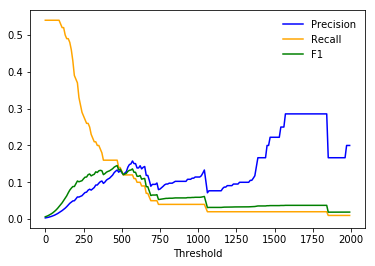

In [22]:
plt.plot(x_th, y_pre, label = 'Precision', color = 'blue')
plt.plot(x_th, y_rec, label = 'Recall', color = 'orange')
plt.plot(x_th, y_f1, label = 'F1', color = 'green')
plt.xlabel('Threshold')
plt.legend()
#plt.show()
plt.savefig("problem2.png")

In [23]:
bacteria_threshold = 470
bacteria_reason = """
Precission tells us how many selected items are relevant and recall tells us how many relevant items are selected, so we want to maximize both of them.
F1 score is the harmonic mean of the precision and recall, so we actually observe F1 curve, 
because with maximizing F1 curve we maximize both precission and recall at the same time. 
We found out that we want to capture the highest F1 value on the graph, which is at 0.14545454545454545 for threshold 470. 
So we choose 470 to be our best threshold (note that step for generating different thresholds is 10, so my result probably deviates 
from the correct maximum of F1 curve).
"""

# SARS-CoV-2

SARS-CoV-2 is the prolific virus which causes the COVID-19 disease. I am sure most of you are well aware of what the disease does, so we'll skip any long-winded introduction. Instead, we'll jump straight into the genome of this pesky little virus.

![](https://www.klinika-golnik.si/storage/_sites/golnik/app/media/Novice/cov-19.jpg)

We again obtain the viral genome from NCBI.

In [24]:
organism_id = "NC_045512"  # SARS-CoV-2

In [25]:
record = load(organism_id)
record

SeqRecord(seq=Seq('ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGATCTCTTGT...AAA'), id='NC_045512.2', name='NC_045512', description='Severe acute respiratory syndrome coronavirus 2 isolate Wuhan-Hu-1, complete genome', dbxrefs=['BioProject:PRJNA485481'])

In [26]:
start_codons = ["ATG"]
stop_codons = ["TAA", "TAG", "TGA"]

In [27]:
print("{:,} bases".format(len(record.seq)))

29,903 bases


## Problem 3

_You_ are now the biologist. This time we have no ground truth annotations about SARS-CoV-2 from NCBI, so it is up to you to find the genes and try to determine what each gene does.

**TASK:**
Run your ORF finder on the SARS-CoV-2 genome. Plot the distribution of ORF lengths (log-scale), similarily to what we did for Paramecium tetraurelia, and save the result to `problem3.png`. Determine a threshold on ORF lengths, and filter the number of ORFs to something you find acceptable. Save your answer into the `covid_threshold` variable. You will have to inspect each sequence manually in the next problem, so set it to something reasonable. We don't want you to spend 10 hours staring at gene descriptions.

In [28]:
print("Finding ORFs using start/stop codons...")
orf_candidates = find_all_orfs(record.seq, start_codons, stop_codons)
print(f"{len(orf_candidates)} ORF candidates found")

plus = []
minus = []
for c in orf_candidates:
    if c[0] == 1:
        plus.append(c)
    else:
        minus.append(c)
        
print(f"{len(plus)} 1 ORF candidates found")
print(f"{len(minus)} - 1 ORF candidates found")

Finding ORFs using start/stop codons...
711 ORF candidates found
329 1 ORF candidates found
382 - 1 ORF candidates found


In [29]:
orf_length = np.array([c[2] - c[1] for c in orf_candidates]) / 3  # divide by 3 for codons

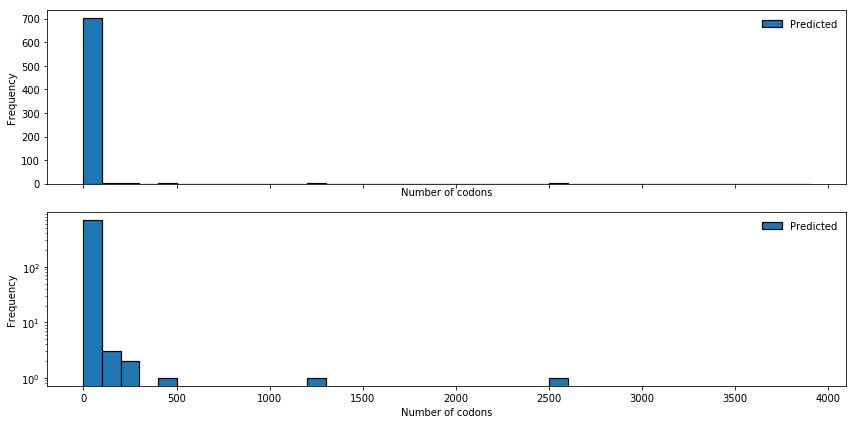

In [30]:
fig, ax = plt.subplots(nrows=2, figsize=(12, 6), sharex=True)
hist_kwargs = dict(bins=list(range(0, 4000, 100)), edgecolor="k", lw=1.2)
for ax_ in ax.ravel():
    ax_.hist(orf_length, color="tab:blue", label="Predicted", **hist_kwargs)
    ax_.set_xlabel("Number of codons"), ax_.set_ylabel("Frequency")
    ax_.legend()
ax[1].set_yscale("log")
plt.tight_layout();

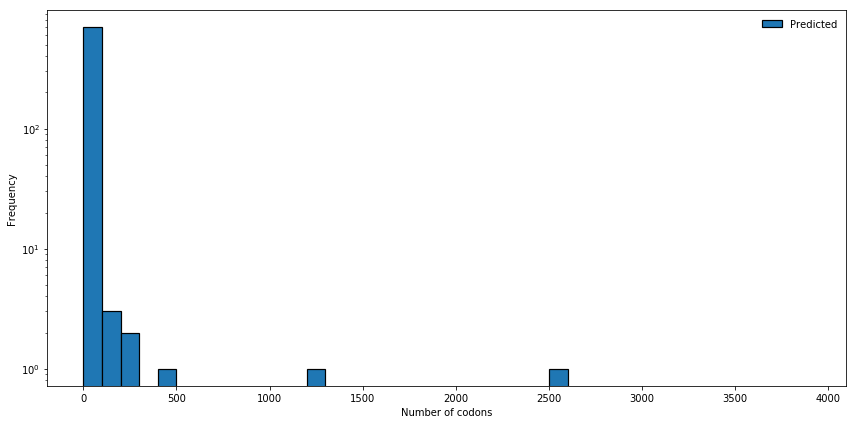

In [31]:
### LOG SCALE -- problem3.png

fig, ax = plt.subplots(nrows=1, figsize=(12, 6), sharex=True)
hist_kwargs = dict(bins=list(range(0, 4000, 100)), edgecolor="k", lw=1.2)

ax.hist(orf_length, color="tab:blue", label="Predicted", **hist_kwargs)
ax.set_xlabel("Number of codons"), ax.set_ylabel("Frequency")
ax.legend()
ax.set_yscale("log")
plt.savefig('problem3.png')
plt.tight_layout();

In [32]:
# Determing threshold
### somewhere between 300 and 500

test_list = []

for l in orf_length:
    if l > 70:
        test_list.append(l)

test_list

[2596.0,
 276.0,
 76.0,
 122.0,
 4406.0,
 1283.0,
 420.0,
 83.0,
 88.0,
 223.0,
 122.0,
 98.0,
 74.0,
 74.0,
 80.0,
 82.0,
 83.0,
 101.0]

In [33]:
covid_threshold = 70

## Problem 4

In the final problem, you will have to use NCBIs blastp online program to determine whether or not each ORF you found is an actual gene, and if it is -- what it does.

BLASTp is a sequence alignment tool that you will learn about in the upcoming lectures. But for now, you can think of it like this: given a sequence, BLAST looks through all the genomes of known animals and sees if there are any regions there that match the query sequence. So, you can look through matching sequences where we'll usually expect to find very closely related organisms. For example, if we have some gene from a brown labrador puppy, we'd probably expect that gene to be farily similar to that same gene in black labrador puppies. Or in the case SARS-CoV-2, the genes will probably be similar to some related coronavirus.

![](https://www.economist.com/img/b/1000/563/90/sites/default/files/20200314_FBD001.jpg)

**TASK**:
Translate each of your ORFs into a protein sequence. You will need to implement the `translate_to_protein` function in `helper_functions.py`. You can verify your implementation against the provided unit tests (your code will be run against different examples for grading). Next, run each protein sequence through [NCBI BLASTp](https://blast.ncbi.nlm.nih.gov/Blast.cgi?PROGRAM=blastp&PAGE_TYPE=BlastSearch&LINK_LOC=blasthome). Look at the picture of the SARS-CoV-2 virus above, and try to match the ORFs you found to each protein type, e.g. ORF1 may be a spike protein, or ORF5 might be an envelope protein. Save your answers into the `covid_proteins` variable as a dict of lists, where the dict keys are what you see in the picture. The lists should hold the tuples specifying the appropriate ORFs in the same format that is returned by `find_all_orfs`.

You should be able to determine where most proteins go by their names alone. In case the name is not sufficient, set the BLASTp database to _swissprot_ and look at the _COMMENT_ field on the matched genes.

In [34]:
def ORFs_TH(candidates, th):
    """ Returns a list with ORF candidates with len > threshold. """
    ORF_list = []
    for i in range(len(candidates)):
        if orf_length[i] > th:
            ORF_list.append(candidates[i])
    return ORF_list 

In [35]:
ORF_list = ORFs_TH(orf_candidates, covid_threshold)
ORF_list

[(1, 13767, 21555),
 (1, 25392, 26220),
 (1, 26244, 26472),
 (1, 27393, 27759),
 (1, 265, 13483),
 (1, 21535, 25384),
 (1, 28273, 29533),
 (1, 2957, 3206),
 (1, 21935, 22199),
 (1, 26522, 27191),
 (1, 27893, 28259),
 (1, 28283, 28577),
 (1, 28733, 28955),
 (-1, 25585, 25807),
 (-1, 23197, 23437),
 (-1, 421, 667),
 (-1, 23073, 23322),
 (-1, 6186, 6489)]

In [36]:
ORFs_sequence = []

for element in ORF_list:
    strand, start, stop = element
    sequence = record.seq[start : stop]
    if strand == - 1:
        sequence = sequence.reverse_complement()
    ORFs_sequence.append(sequence)


In [37]:
proteins = []

for seq in ORFs_sequence:
    protein = translate_to_protein(seq)
    proteins.append(protein)
    

In [38]:
covid_proteins = {
    "Envelope protein": [(1, 26244, 26472)],  # (strand, start location, stop location), don't forget to the provided example
    "Membrane protein": [(1, 26522, 27191)],
    "Spike protein": [(1, 21535, 25384)],
    "Nucleocapsid protein": [(1, 28273, 29533)],
    "Lipid membrane": [],
}